### Связь бизнес-показателей и DS-метрик

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, plot_confusion_matrix, plot_precision_recall_curve, precision_recall_curve, recall_score, plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve, KFold, GridSearchCV, RandomizedSearchCV 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import lightgbm as lgbm, catboost as catb
from xgboost import XGBClassifier


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

import pickle
import random
import itertools

%matplotlib inline

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [5]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

## Рассмотрим разные модели и сравним результаты их работы между собой

Мы будем рассматривать модели с гаперпараметрами по умолчанию без процесса их оптимального подбора

Результаты работы моделей будем записывать в список и затем составим таблицу для сравнения

In [6]:
score_list = []

### 1.LogisticRegression

Добавим классификатор и запустим кросс-валидацию

In [7]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7864503780644487+-0.00470508979002898


Посчитаем precision/recall/f_score

In [8]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


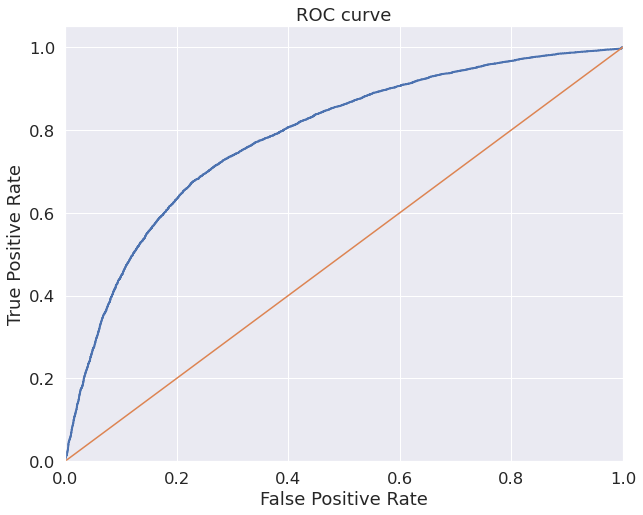

In [105]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [106]:
from sklearn.metrics import roc_auc_score, log_loss

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7840347790421852
log loss score: 0.5779604008230663


In [107]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Посомтрим на матрицу ошибок

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


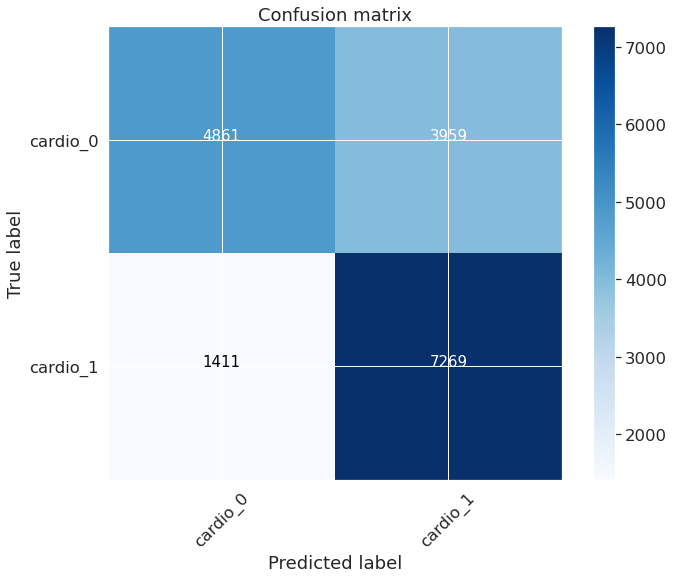

In [108]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [109]:
score_list.append(['LogReg', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1]), log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])])

### 2.RandomForestClassifier

In [110]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7746122528862524+-0.002826859521452832


In [111]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.350000, F-Score=0.719, Precision=0.643, Recall=0.816


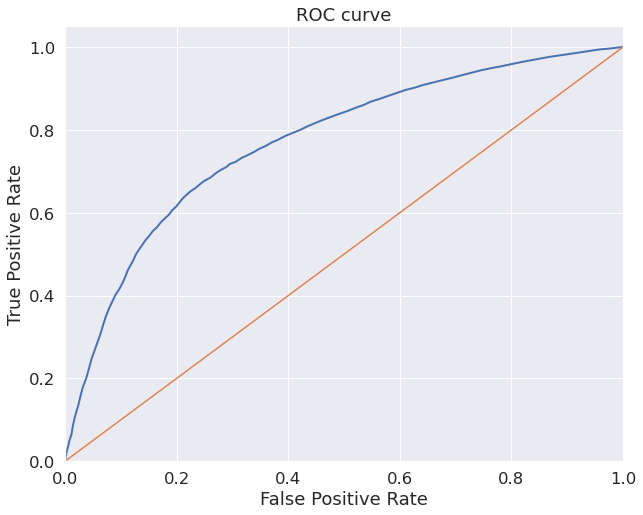

In [112]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [113]:
from sklearn.metrics import roc_auc_score, log_loss

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7710366181802983
log loss score: 0.5992984853728378


Confusion matrix, without normalization
[[4991 3829]
 [1663 7017]]


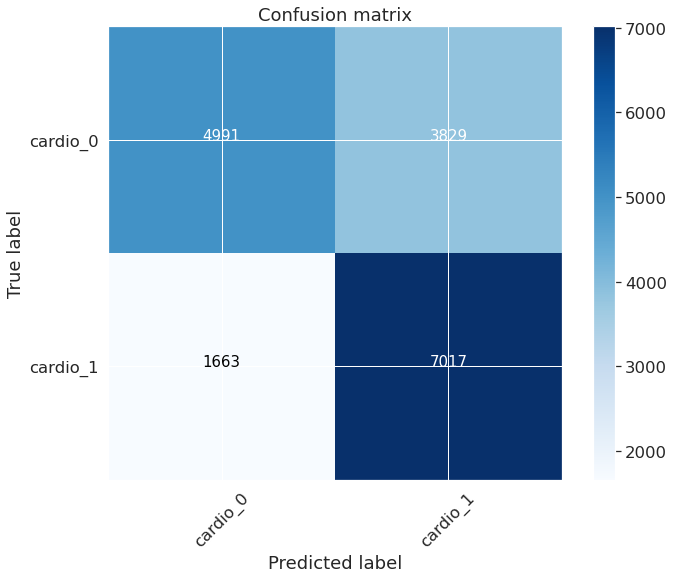

In [114]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [115]:
score_list.append(['RandomForest', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1]), log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])])

### 3.KNeighborsClassifier

CV score is 0.6894397105268195+-0.0035928076517220946
Best Threshold=0.400000, F-Score=0.686, Precision=0.588, Recall=0.822


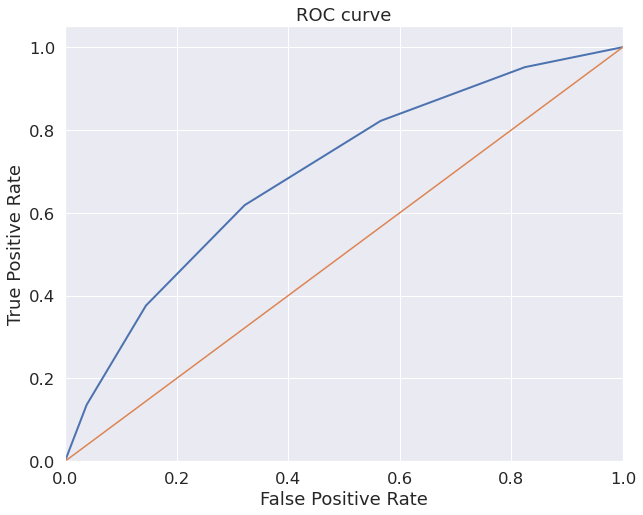

roc auc score: 0.6940984174007545
log loss score: 2.0495466723151554
Confusion matrix, without normalization
[[5979 2841]
 [3311 5369]]


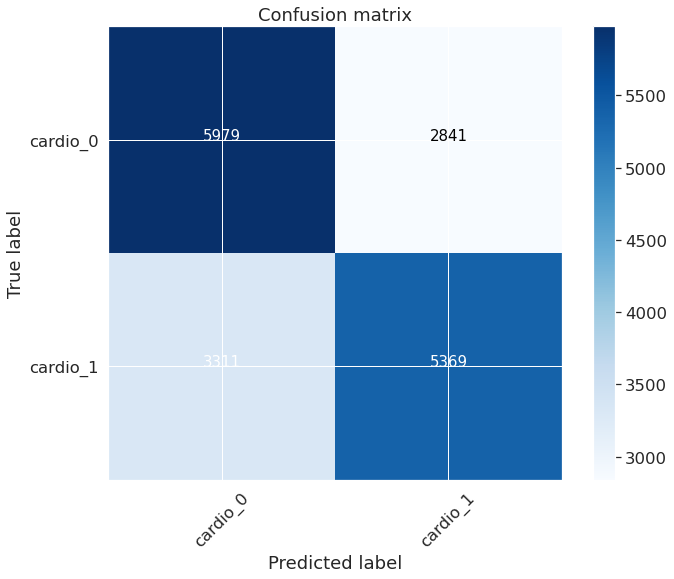

In [116]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', KNeighborsClassifier()),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]


b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))


sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()


from sklearn.metrics import roc_auc_score, log_loss

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))


#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

score_list.append(['KNClass', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1]), log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])])


### 4.lgbm

CV score is 0.8014459205896521+-0.00375307048678631
Best Threshold=0.344797, F-Score=0.740, Precision=0.661, Recall=0.840


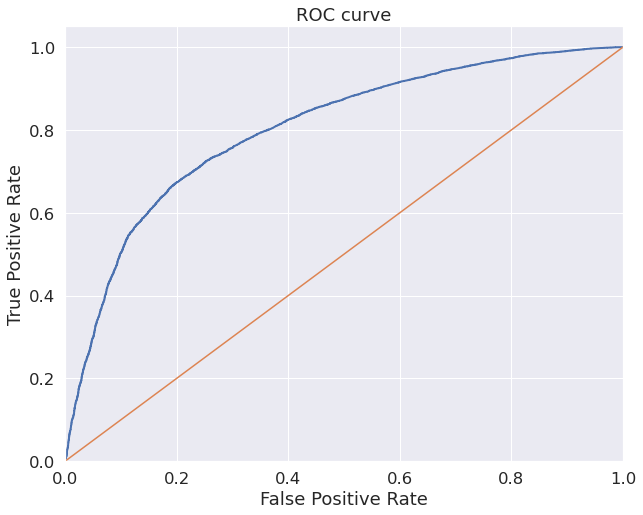

roc auc score: 0.8016890681003584
log loss score: 0.5405794864832395
Confusion matrix, without normalization
[[5079 3741]
 [1393 7287]]


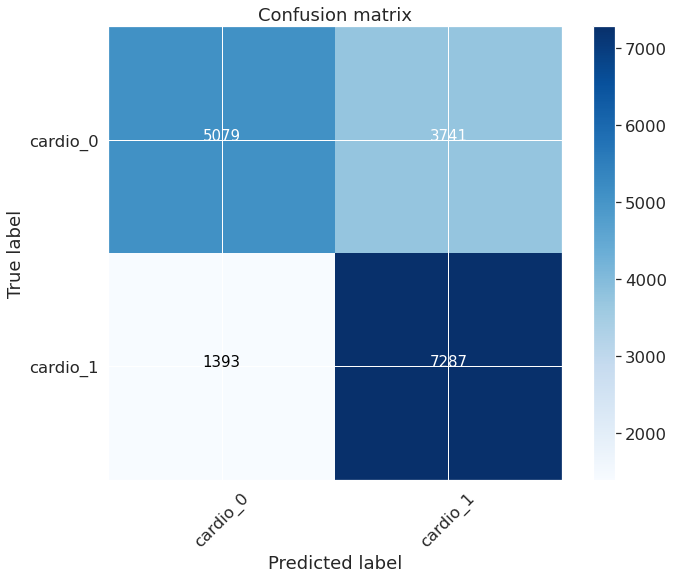

In [117]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', lgbm.LGBMClassifier(random_state=21)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]


b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))


sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()


from sklearn.metrics import roc_auc_score, log_loss

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))


#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

score_list.append(['lgbm', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1]), log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])])

### 5.catboost

Learning rate set to 0.050823
0:	learn: 0.6784913	total: 4.12ms	remaining: 4.12s
1:	learn: 0.6656316	total: 26.2ms	remaining: 13.1s
2:	learn: 0.6538430	total: 37.4ms	remaining: 12.4s
3:	learn: 0.6430401	total: 48ms	remaining: 12s
4:	learn: 0.6332771	total: 63.2ms	remaining: 12.6s
5:	learn: 0.6247981	total: 70.1ms	remaining: 11.6s
6:	learn: 0.6168729	total: 78ms	remaining: 11.1s
7:	learn: 0.6099085	total: 85.9ms	remaining: 10.6s
8:	learn: 0.6036205	total: 92.3ms	remaining: 10.2s
9:	learn: 0.5981368	total: 102ms	remaining: 10.1s
10:	learn: 0.5929563	total: 107ms	remaining: 9.58s
11:	learn: 0.5886249	total: 112ms	remaining: 9.2s
12:	learn: 0.5844865	total: 118ms	remaining: 8.99s
13:	learn: 0.5807446	total: 126ms	remaining: 8.89s
14:	learn: 0.5775804	total: 132ms	remaining: 8.68s
15:	learn: 0.5744739	total: 136ms	remaining: 8.39s
16:	learn: 0.5717322	total: 140ms	remaining: 8.12s
17:	learn: 0.5693288	total: 145ms	remaining: 7.88s
18:	learn: 0.5671969	total: 149ms	remaining: 7.7s
19:	learn:

196:	learn: 0.5306301	total: 784ms	remaining: 3.2s
197:	learn: 0.5305855	total: 788ms	remaining: 3.19s
198:	learn: 0.5305227	total: 793ms	remaining: 3.19s
199:	learn: 0.5304678	total: 798ms	remaining: 3.19s
200:	learn: 0.5304453	total: 802ms	remaining: 3.19s
201:	learn: 0.5304145	total: 806ms	remaining: 3.18s
202:	learn: 0.5303778	total: 810ms	remaining: 3.18s
203:	learn: 0.5303574	total: 814ms	remaining: 3.17s
204:	learn: 0.5303060	total: 818ms	remaining: 3.17s
205:	learn: 0.5302516	total: 822ms	remaining: 3.17s
206:	learn: 0.5302096	total: 826ms	remaining: 3.16s
207:	learn: 0.5301572	total: 829ms	remaining: 3.16s
208:	learn: 0.5300998	total: 833ms	remaining: 3.15s
209:	learn: 0.5300531	total: 837ms	remaining: 3.15s
210:	learn: 0.5300001	total: 841ms	remaining: 3.14s
211:	learn: 0.5299704	total: 844ms	remaining: 3.14s
212:	learn: 0.5299285	total: 848ms	remaining: 3.13s
213:	learn: 0.5299137	total: 852ms	remaining: 3.13s
214:	learn: 0.5298781	total: 855ms	remaining: 3.12s
215:	learn: 0

404:	learn: 0.5210391	total: 1.57s	remaining: 2.3s
405:	learn: 0.5209467	total: 1.57s	remaining: 2.3s
406:	learn: 0.5209094	total: 1.57s	remaining: 2.3s
407:	learn: 0.5208744	total: 1.58s	remaining: 2.29s
408:	learn: 0.5208365	total: 1.58s	remaining: 2.29s
409:	learn: 0.5207761	total: 1.59s	remaining: 2.29s
410:	learn: 0.5207399	total: 1.59s	remaining: 2.28s
411:	learn: 0.5207042	total: 1.6s	remaining: 2.28s
412:	learn: 0.5206706	total: 1.6s	remaining: 2.27s
413:	learn: 0.5206139	total: 1.6s	remaining: 2.27s
414:	learn: 0.5205534	total: 1.61s	remaining: 2.26s
415:	learn: 0.5205190	total: 1.61s	remaining: 2.26s
416:	learn: 0.5204838	total: 1.61s	remaining: 2.25s
417:	learn: 0.5204283	total: 1.62s	remaining: 2.25s
418:	learn: 0.5203772	total: 1.62s	remaining: 2.25s
419:	learn: 0.5203377	total: 1.62s	remaining: 2.24s
420:	learn: 0.5203062	total: 1.63s	remaining: 2.24s
421:	learn: 0.5202492	total: 1.63s	remaining: 2.23s
422:	learn: 0.5201877	total: 1.63s	remaining: 2.23s
423:	learn: 0.5201

580:	learn: 0.5139250	total: 2.15s	remaining: 1.55s
581:	learn: 0.5138947	total: 2.16s	remaining: 1.55s
582:	learn: 0.5138664	total: 2.16s	remaining: 1.55s
583:	learn: 0.5138246	total: 2.17s	remaining: 1.54s
584:	learn: 0.5137947	total: 2.17s	remaining: 1.54s
585:	learn: 0.5137502	total: 2.17s	remaining: 1.54s
586:	learn: 0.5137068	total: 2.18s	remaining: 1.53s
587:	learn: 0.5136447	total: 2.18s	remaining: 1.53s
588:	learn: 0.5136234	total: 2.19s	remaining: 1.52s
589:	learn: 0.5136000	total: 2.19s	remaining: 1.52s
590:	learn: 0.5135621	total: 2.19s	remaining: 1.52s
591:	learn: 0.5135248	total: 2.19s	remaining: 1.51s
592:	learn: 0.5134784	total: 2.2s	remaining: 1.51s
593:	learn: 0.5134393	total: 2.2s	remaining: 1.5s
594:	learn: 0.5133868	total: 2.21s	remaining: 1.5s
595:	learn: 0.5133678	total: 2.21s	remaining: 1.5s
596:	learn: 0.5133021	total: 2.21s	remaining: 1.49s
597:	learn: 0.5132548	total: 2.21s	remaining: 1.49s
598:	learn: 0.5132391	total: 2.22s	remaining: 1.49s
599:	learn: 0.513

755:	learn: 0.5076562	total: 2.74s	remaining: 885ms
756:	learn: 0.5076343	total: 2.75s	remaining: 882ms
757:	learn: 0.5076009	total: 2.75s	remaining: 878ms
758:	learn: 0.5075732	total: 2.75s	remaining: 875ms
759:	learn: 0.5075236	total: 2.76s	remaining: 871ms
760:	learn: 0.5074967	total: 2.76s	remaining: 868ms
761:	learn: 0.5074397	total: 2.77s	remaining: 864ms
762:	learn: 0.5074117	total: 2.77s	remaining: 861ms
763:	learn: 0.5073826	total: 2.77s	remaining: 857ms
764:	learn: 0.5073807	total: 2.78s	remaining: 853ms
765:	learn: 0.5073605	total: 2.78s	remaining: 849ms
766:	learn: 0.5073149	total: 2.78s	remaining: 846ms
767:	learn: 0.5072809	total: 2.79s	remaining: 842ms
768:	learn: 0.5072507	total: 2.79s	remaining: 838ms
769:	learn: 0.5072140	total: 2.79s	remaining: 835ms
770:	learn: 0.5071487	total: 2.8s	remaining: 831ms
771:	learn: 0.5071449	total: 2.8s	remaining: 827ms
772:	learn: 0.5071413	total: 2.8s	remaining: 823ms
773:	learn: 0.5070927	total: 2.81s	remaining: 820ms
774:	learn: 0.5

929:	learn: 0.5021121	total: 3.33s	remaining: 251ms
930:	learn: 0.5020848	total: 3.33s	remaining: 247ms
931:	learn: 0.5020615	total: 3.34s	remaining: 243ms
932:	learn: 0.5020285	total: 3.34s	remaining: 240ms
933:	learn: 0.5019934	total: 3.34s	remaining: 236ms
934:	learn: 0.5019543	total: 3.35s	remaining: 233ms
935:	learn: 0.5019288	total: 3.35s	remaining: 229ms
936:	learn: 0.5018900	total: 3.35s	remaining: 226ms
937:	learn: 0.5018632	total: 3.36s	remaining: 222ms
938:	learn: 0.5018288	total: 3.36s	remaining: 218ms
939:	learn: 0.5018069	total: 3.37s	remaining: 215ms
940:	learn: 0.5017667	total: 3.37s	remaining: 211ms
941:	learn: 0.5017496	total: 3.37s	remaining: 208ms
942:	learn: 0.5017270	total: 3.38s	remaining: 204ms
943:	learn: 0.5016751	total: 3.38s	remaining: 200ms
944:	learn: 0.5016349	total: 3.38s	remaining: 197ms
945:	learn: 0.5015931	total: 3.39s	remaining: 193ms
946:	learn: 0.5015707	total: 3.39s	remaining: 190ms
947:	learn: 0.5015246	total: 3.39s	remaining: 186ms
948:	learn: 

144:	learn: 0.5315876	total: 494ms	remaining: 2.92s
145:	learn: 0.5314996	total: 498ms	remaining: 2.91s
146:	learn: 0.5314571	total: 502ms	remaining: 2.91s
147:	learn: 0.5314028	total: 506ms	remaining: 2.91s
148:	learn: 0.5313454	total: 510ms	remaining: 2.91s
149:	learn: 0.5312934	total: 514ms	remaining: 2.91s
150:	learn: 0.5312496	total: 517ms	remaining: 2.91s
151:	learn: 0.5311840	total: 521ms	remaining: 2.9s
152:	learn: 0.5311122	total: 524ms	remaining: 2.9s
153:	learn: 0.5310662	total: 528ms	remaining: 2.9s
154:	learn: 0.5310265	total: 531ms	remaining: 2.89s
155:	learn: 0.5309632	total: 535ms	remaining: 2.89s
156:	learn: 0.5309275	total: 538ms	remaining: 2.89s
157:	learn: 0.5308426	total: 541ms	remaining: 2.88s
158:	learn: 0.5308033	total: 544ms	remaining: 2.88s
159:	learn: 0.5307414	total: 548ms	remaining: 2.88s
160:	learn: 0.5307100	total: 551ms	remaining: 2.87s
161:	learn: 0.5306354	total: 554ms	remaining: 2.87s
162:	learn: 0.5305903	total: 558ms	remaining: 2.86s
163:	learn: 0.5

319:	learn: 0.5228936	total: 1.08s	remaining: 2.3s
320:	learn: 0.5228450	total: 1.09s	remaining: 2.3s
321:	learn: 0.5227876	total: 1.09s	remaining: 2.3s
322:	learn: 0.5227355	total: 1.09s	remaining: 2.29s
323:	learn: 0.5226766	total: 1.1s	remaining: 2.29s
324:	learn: 0.5226227	total: 1.1s	remaining: 2.29s
325:	learn: 0.5225793	total: 1.11s	remaining: 2.29s
326:	learn: 0.5225407	total: 1.11s	remaining: 2.28s
327:	learn: 0.5224868	total: 1.11s	remaining: 2.28s
328:	learn: 0.5224151	total: 1.12s	remaining: 2.28s
329:	learn: 0.5223569	total: 1.12s	remaining: 2.27s
330:	learn: 0.5223076	total: 1.12s	remaining: 2.27s
331:	learn: 0.5222544	total: 1.13s	remaining: 2.27s
332:	learn: 0.5222248	total: 1.13s	remaining: 2.26s
333:	learn: 0.5222190	total: 1.13s	remaining: 2.26s
334:	learn: 0.5221815	total: 1.14s	remaining: 2.25s
335:	learn: 0.5221075	total: 1.14s	remaining: 2.25s
336:	learn: 0.5220608	total: 1.14s	remaining: 2.25s
337:	learn: 0.5219906	total: 1.15s	remaining: 2.24s
338:	learn: 0.521

494:	learn: 0.5154300	total: 1.67s	remaining: 1.7s
495:	learn: 0.5153908	total: 1.67s	remaining: 1.7s
496:	learn: 0.5153698	total: 1.68s	remaining: 1.7s
497:	learn: 0.5153362	total: 1.68s	remaining: 1.69s
498:	learn: 0.5152886	total: 1.68s	remaining: 1.69s
499:	learn: 0.5152452	total: 1.69s	remaining: 1.69s
500:	learn: 0.5151885	total: 1.69s	remaining: 1.68s
501:	learn: 0.5151280	total: 1.69s	remaining: 1.68s
502:	learn: 0.5151045	total: 1.7s	remaining: 1.68s
503:	learn: 0.5150759	total: 1.7s	remaining: 1.67s
504:	learn: 0.5150478	total: 1.7s	remaining: 1.67s
505:	learn: 0.5150105	total: 1.71s	remaining: 1.67s
506:	learn: 0.5149697	total: 1.71s	remaining: 1.66s
507:	learn: 0.5149461	total: 1.71s	remaining: 1.66s
508:	learn: 0.5149320	total: 1.72s	remaining: 1.66s
509:	learn: 0.5148972	total: 1.72s	remaining: 1.65s
510:	learn: 0.5148669	total: 1.72s	remaining: 1.65s
511:	learn: 0.5148271	total: 1.73s	remaining: 1.65s
512:	learn: 0.5147725	total: 1.73s	remaining: 1.64s
513:	learn: 0.5147

663:	learn: 0.5095429	total: 2.25s	remaining: 1.14s
664:	learn: 0.5095153	total: 2.26s	remaining: 1.14s
665:	learn: 0.5095073	total: 2.26s	remaining: 1.13s
666:	learn: 0.5094662	total: 2.27s	remaining: 1.13s
667:	learn: 0.5094261	total: 2.27s	remaining: 1.13s
668:	learn: 0.5093959	total: 2.27s	remaining: 1.13s
669:	learn: 0.5093492	total: 2.28s	remaining: 1.12s
670:	learn: 0.5093128	total: 2.28s	remaining: 1.12s
671:	learn: 0.5092831	total: 2.29s	remaining: 1.11s
672:	learn: 0.5092529	total: 2.29s	remaining: 1.11s
673:	learn: 0.5092254	total: 2.29s	remaining: 1.11s
674:	learn: 0.5092096	total: 2.29s	remaining: 1.1s
675:	learn: 0.5091678	total: 2.3s	remaining: 1.1s
676:	learn: 0.5091163	total: 2.3s	remaining: 1.1s
677:	learn: 0.5090642	total: 2.31s	remaining: 1.09s
678:	learn: 0.5090248	total: 2.31s	remaining: 1.09s
679:	learn: 0.5089780	total: 2.31s	remaining: 1.09s
680:	learn: 0.5089351	total: 2.31s	remaining: 1.08s
681:	learn: 0.5089100	total: 2.32s	remaining: 1.08s
682:	learn: 0.508

836:	learn: 0.5040553	total: 2.84s	remaining: 554ms
837:	learn: 0.5040155	total: 2.85s	remaining: 550ms
838:	learn: 0.5039996	total: 2.85s	remaining: 547ms
839:	learn: 0.5039496	total: 2.85s	remaining: 544ms
840:	learn: 0.5039157	total: 2.86s	remaining: 540ms
841:	learn: 0.5038768	total: 2.86s	remaining: 537ms
842:	learn: 0.5038583	total: 2.87s	remaining: 534ms
843:	learn: 0.5037992	total: 2.87s	remaining: 530ms
844:	learn: 0.5037708	total: 2.87s	remaining: 527ms
845:	learn: 0.5037481	total: 2.88s	remaining: 524ms
846:	learn: 0.5037179	total: 2.88s	remaining: 520ms
847:	learn: 0.5036663	total: 2.88s	remaining: 517ms
848:	learn: 0.5036295	total: 2.89s	remaining: 514ms
849:	learn: 0.5035843	total: 2.89s	remaining: 510ms
850:	learn: 0.5035488	total: 2.89s	remaining: 507ms
851:	learn: 0.5034967	total: 2.9s	remaining: 503ms
852:	learn: 0.5034960	total: 2.9s	remaining: 500ms
853:	learn: 0.5034607	total: 2.9s	remaining: 496ms
854:	learn: 0.5034284	total: 2.91s	remaining: 493ms
855:	learn: 0.5

Learning rate set to 0.050823
0:	learn: 0.6783026	total: 3.46ms	remaining: 3.46s
1:	learn: 0.6652472	total: 6.99ms	remaining: 3.49s
2:	learn: 0.6530033	total: 10.1ms	remaining: 3.35s
3:	learn: 0.6423604	total: 13.5ms	remaining: 3.35s
4:	learn: 0.6326670	total: 16.6ms	remaining: 3.3s
5:	learn: 0.6238971	total: 20ms	remaining: 3.31s
6:	learn: 0.6159832	total: 23.5ms	remaining: 3.33s
7:	learn: 0.6088791	total: 26.8ms	remaining: 3.32s
8:	learn: 0.6026120	total: 30.2ms	remaining: 3.32s
9:	learn: 0.5970024	total: 33.6ms	remaining: 3.32s
10:	learn: 0.5920165	total: 36.8ms	remaining: 3.31s
11:	learn: 0.5874673	total: 40.3ms	remaining: 3.31s
12:	learn: 0.5834030	total: 43.6ms	remaining: 3.31s
13:	learn: 0.5795837	total: 46.5ms	remaining: 3.27s
14:	learn: 0.5762539	total: 49.9ms	remaining: 3.28s
15:	learn: 0.5732982	total: 52.7ms	remaining: 3.24s
16:	learn: 0.5704109	total: 56.2ms	remaining: 3.25s
17:	learn: 0.5680284	total: 59.5ms	remaining: 3.25s
18:	learn: 0.5657192	total: 62.9ms	remaining: 3

172:	learn: 0.5303714	total: 588ms	remaining: 2.81s
173:	learn: 0.5303474	total: 591ms	remaining: 2.81s
174:	learn: 0.5303175	total: 595ms	remaining: 2.81s
175:	learn: 0.5302450	total: 599ms	remaining: 2.81s
176:	learn: 0.5301781	total: 603ms	remaining: 2.81s
177:	learn: 0.5301624	total: 607ms	remaining: 2.8s
178:	learn: 0.5301094	total: 610ms	remaining: 2.8s
179:	learn: 0.5300814	total: 613ms	remaining: 2.79s
180:	learn: 0.5300366	total: 617ms	remaining: 2.79s
181:	learn: 0.5299912	total: 620ms	remaining: 2.79s
182:	learn: 0.5299428	total: 624ms	remaining: 2.78s
183:	learn: 0.5299044	total: 627ms	remaining: 2.78s
184:	learn: 0.5298360	total: 630ms	remaining: 2.78s
185:	learn: 0.5297919	total: 633ms	remaining: 2.77s
186:	learn: 0.5297396	total: 637ms	remaining: 2.77s
187:	learn: 0.5296618	total: 640ms	remaining: 2.77s
188:	learn: 0.5296180	total: 644ms	remaining: 2.76s
189:	learn: 0.5296087	total: 646ms	remaining: 2.75s
190:	learn: 0.5295409	total: 650ms	remaining: 2.75s
191:	learn: 0.

372:	learn: 0.5214170	total: 1.37s	remaining: 2.31s
373:	learn: 0.5214028	total: 1.38s	remaining: 2.31s
374:	learn: 0.5213735	total: 1.38s	remaining: 2.3s
375:	learn: 0.5213381	total: 1.39s	remaining: 2.3s
376:	learn: 0.5212735	total: 1.39s	remaining: 2.3s
377:	learn: 0.5212233	total: 1.4s	remaining: 2.3s
378:	learn: 0.5211892	total: 1.4s	remaining: 2.3s
379:	learn: 0.5211620	total: 1.41s	remaining: 2.3s
380:	learn: 0.5211069	total: 1.41s	remaining: 2.29s
381:	learn: 0.5210711	total: 1.42s	remaining: 2.29s
382:	learn: 0.5210336	total: 1.42s	remaining: 2.29s
383:	learn: 0.5210281	total: 1.43s	remaining: 2.29s
384:	learn: 0.5210177	total: 1.43s	remaining: 2.28s
385:	learn: 0.5209595	total: 1.43s	remaining: 2.28s
386:	learn: 0.5208917	total: 1.44s	remaining: 2.28s
387:	learn: 0.5208702	total: 1.44s	remaining: 2.28s
388:	learn: 0.5208233	total: 1.45s	remaining: 2.27s
389:	learn: 0.5208202	total: 1.45s	remaining: 2.27s
390:	learn: 0.5207830	total: 1.46s	remaining: 2.27s
391:	learn: 0.520727

543:	learn: 0.5152454	total: 2.16s	remaining: 1.81s
544:	learn: 0.5152014	total: 2.17s	remaining: 1.81s
545:	learn: 0.5151285	total: 2.17s	remaining: 1.81s
546:	learn: 0.5151218	total: 2.18s	remaining: 1.8s
547:	learn: 0.5150857	total: 2.18s	remaining: 1.8s
548:	learn: 0.5150447	total: 2.19s	remaining: 1.8s
549:	learn: 0.5150207	total: 2.19s	remaining: 1.79s
550:	learn: 0.5149810	total: 2.2s	remaining: 1.79s
551:	learn: 0.5149513	total: 2.21s	remaining: 1.79s
552:	learn: 0.5149292	total: 2.21s	remaining: 1.79s
553:	learn: 0.5148670	total: 2.21s	remaining: 1.78s
554:	learn: 0.5148251	total: 2.22s	remaining: 1.78s
555:	learn: 0.5148094	total: 2.22s	remaining: 1.78s
556:	learn: 0.5147823	total: 2.23s	remaining: 1.77s
557:	learn: 0.5147564	total: 2.23s	remaining: 1.77s
558:	learn: 0.5147258	total: 2.24s	remaining: 1.76s
559:	learn: 0.5147109	total: 2.24s	remaining: 1.76s
560:	learn: 0.5146687	total: 2.25s	remaining: 1.76s
561:	learn: 0.5146269	total: 2.25s	remaining: 1.75s
562:	learn: 0.51

713:	learn: 0.5098620	total: 2.96s	remaining: 1.18s
714:	learn: 0.5098258	total: 2.96s	remaining: 1.18s
715:	learn: 0.5097798	total: 2.97s	remaining: 1.18s
716:	learn: 0.5097371	total: 2.97s	remaining: 1.17s
717:	learn: 0.5096929	total: 2.98s	remaining: 1.17s
718:	learn: 0.5096730	total: 2.98s	remaining: 1.17s
719:	learn: 0.5096298	total: 2.99s	remaining: 1.16s
720:	learn: 0.5095700	total: 2.99s	remaining: 1.16s
721:	learn: 0.5095398	total: 3s	remaining: 1.15s
722:	learn: 0.5095190	total: 3s	remaining: 1.15s
723:	learn: 0.5094931	total: 3.01s	remaining: 1.15s
724:	learn: 0.5094834	total: 3.01s	remaining: 1.14s
725:	learn: 0.5094709	total: 3.02s	remaining: 1.14s
726:	learn: 0.5094172	total: 3.02s	remaining: 1.13s
727:	learn: 0.5093897	total: 3.02s	remaining: 1.13s
728:	learn: 0.5093401	total: 3.03s	remaining: 1.13s
729:	learn: 0.5093022	total: 3.03s	remaining: 1.12s
730:	learn: 0.5092648	total: 3.04s	remaining: 1.12s
731:	learn: 0.5092162	total: 3.04s	remaining: 1.11s
732:	learn: 0.5091

882:	learn: 0.5040655	total: 3.75s	remaining: 496ms
883:	learn: 0.5040379	total: 3.75s	remaining: 492ms
884:	learn: 0.5039831	total: 3.75s	remaining: 488ms
885:	learn: 0.5039822	total: 3.76s	remaining: 484ms
886:	learn: 0.5039516	total: 3.77s	remaining: 480ms
887:	learn: 0.5039027	total: 3.77s	remaining: 476ms
888:	learn: 0.5038751	total: 3.78s	remaining: 472ms
889:	learn: 0.5038530	total: 3.78s	remaining: 467ms
890:	learn: 0.5038196	total: 3.79s	remaining: 463ms
891:	learn: 0.5037966	total: 3.79s	remaining: 459ms
892:	learn: 0.5037834	total: 3.79s	remaining: 455ms
893:	learn: 0.5037571	total: 3.8s	remaining: 450ms
894:	learn: 0.5037240	total: 3.8s	remaining: 446ms
895:	learn: 0.5036958	total: 3.81s	remaining: 442ms
896:	learn: 0.5036622	total: 3.81s	remaining: 438ms
897:	learn: 0.5036215	total: 3.82s	remaining: 434ms
898:	learn: 0.5036015	total: 3.82s	remaining: 429ms
899:	learn: 0.5035972	total: 3.83s	remaining: 425ms
900:	learn: 0.5035740	total: 3.83s	remaining: 421ms
901:	learn: 0.

43:	learn: 0.5415288	total: 193ms	remaining: 4.19s
44:	learn: 0.5411710	total: 198ms	remaining: 4.2s
45:	learn: 0.5407719	total: 203ms	remaining: 4.21s
46:	learn: 0.5404900	total: 208ms	remaining: 4.22s
47:	learn: 0.5402273	total: 214ms	remaining: 4.24s
48:	learn: 0.5399173	total: 219ms	remaining: 4.24s
49:	learn: 0.5396753	total: 224ms	remaining: 4.25s
50:	learn: 0.5393983	total: 228ms	remaining: 4.24s
51:	learn: 0.5391022	total: 233ms	remaining: 4.24s
52:	learn: 0.5388543	total: 237ms	remaining: 4.24s
53:	learn: 0.5386211	total: 242ms	remaining: 4.24s
54:	learn: 0.5384425	total: 246ms	remaining: 4.23s
55:	learn: 0.5382410	total: 251ms	remaining: 4.22s
56:	learn: 0.5380045	total: 255ms	remaining: 4.22s
57:	learn: 0.5378214	total: 260ms	remaining: 4.21s
58:	learn: 0.5376449	total: 264ms	remaining: 4.21s
59:	learn: 0.5374386	total: 269ms	remaining: 4.21s
60:	learn: 0.5372021	total: 273ms	remaining: 4.2s
61:	learn: 0.5369742	total: 278ms	remaining: 4.2s
62:	learn: 0.5367513	total: 282ms	

214:	learn: 0.5265566	total: 981ms	remaining: 3.58s
215:	learn: 0.5265012	total: 986ms	remaining: 3.58s
216:	learn: 0.5264513	total: 991ms	remaining: 3.58s
217:	learn: 0.5264254	total: 996ms	remaining: 3.57s
218:	learn: 0.5264020	total: 1s	remaining: 3.57s
219:	learn: 0.5263580	total: 1.01s	remaining: 3.57s
220:	learn: 0.5263211	total: 1.01s	remaining: 3.56s
221:	learn: 0.5262633	total: 1.02s	remaining: 3.56s
222:	learn: 0.5262076	total: 1.02s	remaining: 3.56s
223:	learn: 0.5261600	total: 1.02s	remaining: 3.55s
224:	learn: 0.5261058	total: 1.03s	remaining: 3.55s
225:	learn: 0.5260707	total: 1.03s	remaining: 3.54s
226:	learn: 0.5260397	total: 1.04s	remaining: 3.54s
227:	learn: 0.5259872	total: 1.04s	remaining: 3.53s
228:	learn: 0.5259633	total: 1.05s	remaining: 3.53s
229:	learn: 0.5259315	total: 1.05s	remaining: 3.52s
230:	learn: 0.5258892	total: 1.06s	remaining: 3.52s
231:	learn: 0.5258576	total: 1.06s	remaining: 3.51s
232:	learn: 0.5257991	total: 1.07s	remaining: 3.51s
233:	learn: 0.5

387:	learn: 0.5189211	total: 1.77s	remaining: 2.79s
388:	learn: 0.5188909	total: 1.77s	remaining: 2.79s
389:	learn: 0.5188180	total: 1.78s	remaining: 2.78s
390:	learn: 0.5187827	total: 1.78s	remaining: 2.78s
391:	learn: 0.5187480	total: 1.79s	remaining: 2.78s
392:	learn: 0.5187074	total: 1.79s	remaining: 2.77s
393:	learn: 0.5186801	total: 1.8s	remaining: 2.77s
394:	learn: 0.5186494	total: 1.8s	remaining: 2.76s
395:	learn: 0.5186139	total: 1.81s	remaining: 2.76s
396:	learn: 0.5185524	total: 1.81s	remaining: 2.75s
397:	learn: 0.5185147	total: 1.82s	remaining: 2.75s
398:	learn: 0.5184503	total: 1.82s	remaining: 2.75s
399:	learn: 0.5184006	total: 1.83s	remaining: 2.74s
400:	learn: 0.5183538	total: 1.83s	remaining: 2.74s
401:	learn: 0.5182998	total: 1.84s	remaining: 2.73s
402:	learn: 0.5182597	total: 1.84s	remaining: 2.73s
403:	learn: 0.5182274	total: 1.84s	remaining: 2.72s
404:	learn: 0.5181839	total: 1.85s	remaining: 2.72s
405:	learn: 0.5181786	total: 1.85s	remaining: 2.71s
406:	learn: 0.

560:	learn: 0.5120763	total: 2.56s	remaining: 2s
561:	learn: 0.5120180	total: 2.56s	remaining: 2s
562:	learn: 0.5120156	total: 2.57s	remaining: 1.99s
563:	learn: 0.5119500	total: 2.57s	remaining: 1.99s
564:	learn: 0.5119181	total: 2.58s	remaining: 1.99s
565:	learn: 0.5118758	total: 2.58s	remaining: 1.98s
566:	learn: 0.5118346	total: 2.59s	remaining: 1.98s
567:	learn: 0.5117853	total: 2.59s	remaining: 1.97s
568:	learn: 0.5117377	total: 2.6s	remaining: 1.97s
569:	learn: 0.5117064	total: 2.6s	remaining: 1.96s
570:	learn: 0.5116683	total: 2.61s	remaining: 1.96s
571:	learn: 0.5116374	total: 2.61s	remaining: 1.95s
572:	learn: 0.5116004	total: 2.62s	remaining: 1.95s
573:	learn: 0.5115979	total: 2.62s	remaining: 1.94s
574:	learn: 0.5115343	total: 2.62s	remaining: 1.94s
575:	learn: 0.5114995	total: 2.63s	remaining: 1.94s
576:	learn: 0.5114536	total: 2.63s	remaining: 1.93s
577:	learn: 0.5114267	total: 2.64s	remaining: 1.93s
578:	learn: 0.5113622	total: 2.64s	remaining: 1.92s
579:	learn: 0.511335

732:	learn: 0.5056827	total: 3.34s	remaining: 1.22s
733:	learn: 0.5056638	total: 3.35s	remaining: 1.21s
734:	learn: 0.5056617	total: 3.35s	remaining: 1.21s
735:	learn: 0.5056071	total: 3.36s	remaining: 1.21s
736:	learn: 0.5055692	total: 3.36s	remaining: 1.2s
737:	learn: 0.5055544	total: 3.37s	remaining: 1.2s
738:	learn: 0.5055114	total: 3.37s	remaining: 1.19s
739:	learn: 0.5054701	total: 3.38s	remaining: 1.19s
740:	learn: 0.5054273	total: 3.38s	remaining: 1.18s
741:	learn: 0.5053918	total: 3.39s	remaining: 1.18s
742:	learn: 0.5053720	total: 3.39s	remaining: 1.17s
743:	learn: 0.5053485	total: 3.4s	remaining: 1.17s
744:	learn: 0.5053233	total: 3.4s	remaining: 1.16s
745:	learn: 0.5052816	total: 3.4s	remaining: 1.16s
746:	learn: 0.5052467	total: 3.41s	remaining: 1.16s
747:	learn: 0.5052351	total: 3.41s	remaining: 1.15s
748:	learn: 0.5052103	total: 3.42s	remaining: 1.15s
749:	learn: 0.5051687	total: 3.42s	remaining: 1.14s
750:	learn: 0.5051324	total: 3.43s	remaining: 1.14s
751:	learn: 0.505

906:	learn: 0.5000568	total: 4.14s	remaining: 424ms
907:	learn: 0.5000029	total: 4.14s	remaining: 420ms
908:	learn: 0.4999532	total: 4.15s	remaining: 415ms
909:	learn: 0.4999305	total: 4.15s	remaining: 411ms
910:	learn: 0.4998821	total: 4.16s	remaining: 406ms
911:	learn: 0.4998381	total: 4.16s	remaining: 402ms
912:	learn: 0.4997955	total: 4.17s	remaining: 397ms
913:	learn: 0.4997820	total: 4.17s	remaining: 393ms
914:	learn: 0.4997565	total: 4.18s	remaining: 388ms
915:	learn: 0.4997151	total: 4.18s	remaining: 383ms
916:	learn: 0.4997131	total: 4.18s	remaining: 379ms
917:	learn: 0.4996648	total: 4.19s	remaining: 374ms
918:	learn: 0.4996639	total: 4.19s	remaining: 370ms
919:	learn: 0.4996325	total: 4.2s	remaining: 365ms
920:	learn: 0.4996313	total: 4.2s	remaining: 361ms
921:	learn: 0.4996183	total: 4.21s	remaining: 356ms
922:	learn: 0.4995593	total: 4.21s	remaining: 351ms
923:	learn: 0.4995217	total: 4.22s	remaining: 347ms
924:	learn: 0.4995093	total: 4.22s	remaining: 342ms
925:	learn: 0.

95:	learn: 0.5360246	total: 495ms	remaining: 4.66s
96:	learn: 0.5359244	total: 501ms	remaining: 4.66s
97:	learn: 0.5359001	total: 507ms	remaining: 4.66s
98:	learn: 0.5358607	total: 513ms	remaining: 4.67s
99:	learn: 0.5357591	total: 520ms	remaining: 4.68s
100:	learn: 0.5356805	total: 526ms	remaining: 4.68s
101:	learn: 0.5356480	total: 531ms	remaining: 4.68s
102:	learn: 0.5355352	total: 537ms	remaining: 4.67s
103:	learn: 0.5354168	total: 542ms	remaining: 4.67s
104:	learn: 0.5353632	total: 547ms	remaining: 4.66s
105:	learn: 0.5353152	total: 552ms	remaining: 4.66s
106:	learn: 0.5352445	total: 557ms	remaining: 4.65s
107:	learn: 0.5351810	total: 563ms	remaining: 4.65s
108:	learn: 0.5351208	total: 568ms	remaining: 4.65s
109:	learn: 0.5350825	total: 574ms	remaining: 4.64s
110:	learn: 0.5350741	total: 577ms	remaining: 4.62s
111:	learn: 0.5350341	total: 582ms	remaining: 4.62s
112:	learn: 0.5349412	total: 588ms	remaining: 4.61s
113:	learn: 0.5348796	total: 593ms	remaining: 4.61s
114:	learn: 0.534

292:	learn: 0.5260208	total: 1.48s	remaining: 3.57s
293:	learn: 0.5259859	total: 1.48s	remaining: 3.56s
294:	learn: 0.5259381	total: 1.49s	remaining: 3.56s
295:	learn: 0.5258785	total: 1.49s	remaining: 3.55s
296:	learn: 0.5258160	total: 1.5s	remaining: 3.55s
297:	learn: 0.5257890	total: 1.5s	remaining: 3.54s
298:	learn: 0.5257388	total: 1.51s	remaining: 3.54s
299:	learn: 0.5257323	total: 1.51s	remaining: 3.53s
300:	learn: 0.5256784	total: 1.52s	remaining: 3.52s
301:	learn: 0.5256338	total: 1.52s	remaining: 3.52s
302:	learn: 0.5256052	total: 1.52s	remaining: 3.51s
303:	learn: 0.5255436	total: 1.53s	remaining: 3.5s
304:	learn: 0.5254947	total: 1.53s	remaining: 3.5s
305:	learn: 0.5254870	total: 1.54s	remaining: 3.49s
306:	learn: 0.5254199	total: 1.54s	remaining: 3.48s
307:	learn: 0.5253758	total: 1.55s	remaining: 3.48s
308:	learn: 0.5253690	total: 1.55s	remaining: 3.47s
309:	learn: 0.5253248	total: 1.55s	remaining: 3.46s
310:	learn: 0.5252835	total: 1.56s	remaining: 3.46s
311:	learn: 0.52

468:	learn: 0.5186872	total: 2.27s	remaining: 2.57s
469:	learn: 0.5186316	total: 2.28s	remaining: 2.57s
470:	learn: 0.5185806	total: 2.28s	remaining: 2.56s
471:	learn: 0.5185322	total: 2.29s	remaining: 2.56s
472:	learn: 0.5185278	total: 2.29s	remaining: 2.55s
473:	learn: 0.5185002	total: 2.3s	remaining: 2.55s
474:	learn: 0.5184500	total: 2.3s	remaining: 2.54s
475:	learn: 0.5183973	total: 2.31s	remaining: 2.54s
476:	learn: 0.5183635	total: 2.31s	remaining: 2.54s
477:	learn: 0.5183544	total: 2.32s	remaining: 2.53s
478:	learn: 0.5183333	total: 2.32s	remaining: 2.52s
479:	learn: 0.5183039	total: 2.33s	remaining: 2.52s
480:	learn: 0.5182779	total: 2.33s	remaining: 2.51s
481:	learn: 0.5182547	total: 2.33s	remaining: 2.51s
482:	learn: 0.5182118	total: 2.34s	remaining: 2.5s
483:	learn: 0.5181874	total: 2.34s	remaining: 2.5s
484:	learn: 0.5181541	total: 2.35s	remaining: 2.49s
485:	learn: 0.5181390	total: 2.35s	remaining: 2.49s
486:	learn: 0.5180863	total: 2.35s	remaining: 2.48s
487:	learn: 0.51

643:	learn: 0.5124687	total: 3.06s	remaining: 1.69s
644:	learn: 0.5124155	total: 3.06s	remaining: 1.69s
645:	learn: 0.5123877	total: 3.07s	remaining: 1.68s
646:	learn: 0.5123620	total: 3.08s	remaining: 1.68s
647:	learn: 0.5123061	total: 3.08s	remaining: 1.67s
648:	learn: 0.5122964	total: 3.09s	remaining: 1.67s
649:	learn: 0.5122648	total: 3.09s	remaining: 1.66s
650:	learn: 0.5122185	total: 3.1s	remaining: 1.66s
651:	learn: 0.5121794	total: 3.1s	remaining: 1.65s
652:	learn: 0.5121360	total: 3.1s	remaining: 1.65s
653:	learn: 0.5121088	total: 3.11s	remaining: 1.64s
654:	learn: 0.5120587	total: 3.11s	remaining: 1.64s
655:	learn: 0.5120310	total: 3.12s	remaining: 1.64s
656:	learn: 0.5120007	total: 3.12s	remaining: 1.63s
657:	learn: 0.5119673	total: 3.13s	remaining: 1.63s
658:	learn: 0.5119371	total: 3.13s	remaining: 1.62s
659:	learn: 0.5119118	total: 3.13s	remaining: 1.61s
660:	learn: 0.5118816	total: 3.14s	remaining: 1.61s
661:	learn: 0.5118394	total: 3.14s	remaining: 1.6s
662:	learn: 0.51

819:	learn: 0.5065526	total: 3.85s	remaining: 845ms
820:	learn: 0.5065054	total: 3.86s	remaining: 841ms
821:	learn: 0.5064590	total: 3.86s	remaining: 836ms
822:	learn: 0.5064438	total: 3.87s	remaining: 831ms
823:	learn: 0.5064094	total: 3.87s	remaining: 827ms
824:	learn: 0.5063883	total: 3.88s	remaining: 822ms
825:	learn: 0.5063504	total: 3.88s	remaining: 818ms
826:	learn: 0.5063232	total: 3.89s	remaining: 813ms
827:	learn: 0.5062916	total: 3.89s	remaining: 808ms
828:	learn: 0.5062611	total: 3.9s	remaining: 804ms
829:	learn: 0.5062486	total: 3.9s	remaining: 799ms
830:	learn: 0.5062415	total: 3.9s	remaining: 794ms
831:	learn: 0.5062000	total: 3.91s	remaining: 789ms
832:	learn: 0.5061617	total: 3.91s	remaining: 785ms
833:	learn: 0.5061540	total: 3.92s	remaining: 780ms
834:	learn: 0.5061529	total: 3.92s	remaining: 775ms
835:	learn: 0.5061225	total: 3.93s	remaining: 770ms
836:	learn: 0.5060759	total: 3.93s	remaining: 766ms
837:	learn: 0.5060292	total: 3.94s	remaining: 761ms
838:	learn: 0.5

989:	learn: 0.5011909	total: 4.64s	remaining: 46.8ms
990:	learn: 0.5011528	total: 4.64s	remaining: 42.2ms
991:	learn: 0.5011315	total: 4.65s	remaining: 37.5ms
992:	learn: 0.5011095	total: 4.65s	remaining: 32.8ms
993:	learn: 0.5010965	total: 4.66s	remaining: 28.1ms
994:	learn: 0.5010940	total: 4.66s	remaining: 23.4ms
995:	learn: 0.5010657	total: 4.67s	remaining: 18.7ms
996:	learn: 0.5010429	total: 4.67s	remaining: 14.1ms
997:	learn: 0.5009899	total: 4.68s	remaining: 9.37ms
998:	learn: 0.5009389	total: 4.68s	remaining: 4.69ms
999:	learn: 0.5009378	total: 4.68s	remaining: 0us
CV score is 0.8018366774776873+-0.003907481673929621
Learning rate set to 0.055904
0:	learn: 0.6770232	total: 4.85ms	remaining: 4.85s
1:	learn: 0.6630122	total: 9.16ms	remaining: 4.57s
2:	learn: 0.6500727	total: 13.5ms	remaining: 4.49s
3:	learn: 0.6386803	total: 18.3ms	remaining: 4.55s
4:	learn: 0.6285132	total: 22.6ms	remaining: 4.5s
5:	learn: 0.6194673	total: 27.5ms	remaining: 4.56s
6:	learn: 0.6112929	total: 32.5m

172:	learn: 0.5311849	total: 869ms	remaining: 4.15s
173:	learn: 0.5311388	total: 875ms	remaining: 4.15s
174:	learn: 0.5310905	total: 880ms	remaining: 4.15s
175:	learn: 0.5310616	total: 887ms	remaining: 4.15s
176:	learn: 0.5310201	total: 892ms	remaining: 4.15s
177:	learn: 0.5309507	total: 897ms	remaining: 4.14s
178:	learn: 0.5309099	total: 903ms	remaining: 4.14s
179:	learn: 0.5308678	total: 907ms	remaining: 4.13s
180:	learn: 0.5308327	total: 912ms	remaining: 4.13s
181:	learn: 0.5308043	total: 917ms	remaining: 4.12s
182:	learn: 0.5307773	total: 922ms	remaining: 4.12s
183:	learn: 0.5307369	total: 927ms	remaining: 4.11s
184:	learn: 0.5307156	total: 932ms	remaining: 4.11s
185:	learn: 0.5306769	total: 937ms	remaining: 4.1s
186:	learn: 0.5305993	total: 942ms	remaining: 4.1s
187:	learn: 0.5305512	total: 948ms	remaining: 4.09s
188:	learn: 0.5305186	total: 953ms	remaining: 4.09s
189:	learn: 0.5304841	total: 958ms	remaining: 4.08s
190:	learn: 0.5303975	total: 963ms	remaining: 4.08s
191:	learn: 0.

367:	learn: 0.5228327	total: 1.86s	remaining: 3.19s
368:	learn: 0.5227929	total: 1.86s	remaining: 3.19s
369:	learn: 0.5227476	total: 1.87s	remaining: 3.18s
370:	learn: 0.5227262	total: 1.88s	remaining: 3.18s
371:	learn: 0.5227095	total: 1.88s	remaining: 3.18s
372:	learn: 0.5226872	total: 1.89s	remaining: 3.17s
373:	learn: 0.5226513	total: 1.89s	remaining: 3.17s
374:	learn: 0.5226201	total: 1.9s	remaining: 3.16s
375:	learn: 0.5225670	total: 1.9s	remaining: 3.16s
376:	learn: 0.5225321	total: 1.91s	remaining: 3.15s
377:	learn: 0.5224949	total: 1.91s	remaining: 3.15s
378:	learn: 0.5224716	total: 1.92s	remaining: 3.14s
379:	learn: 0.5224196	total: 1.92s	remaining: 3.13s
380:	learn: 0.5223510	total: 1.93s	remaining: 3.13s
381:	learn: 0.5223484	total: 1.93s	remaining: 3.12s
382:	learn: 0.5222948	total: 1.94s	remaining: 3.12s
383:	learn: 0.5222546	total: 1.94s	remaining: 3.11s
384:	learn: 0.5222068	total: 1.95s	remaining: 3.11s
385:	learn: 0.5221562	total: 1.95s	remaining: 3.1s
386:	learn: 0.5

564:	learn: 0.5159979	total: 2.85s	remaining: 2.19s
565:	learn: 0.5159681	total: 2.86s	remaining: 2.19s
566:	learn: 0.5159234	total: 2.86s	remaining: 2.19s
567:	learn: 0.5158492	total: 2.87s	remaining: 2.18s
568:	learn: 0.5158254	total: 2.87s	remaining: 2.18s
569:	learn: 0.5157745	total: 2.88s	remaining: 2.17s
570:	learn: 0.5157457	total: 2.88s	remaining: 2.17s
571:	learn: 0.5156970	total: 2.89s	remaining: 2.16s
572:	learn: 0.5156641	total: 2.9s	remaining: 2.16s
573:	learn: 0.5156316	total: 2.9s	remaining: 2.15s
574:	learn: 0.5155868	total: 2.9s	remaining: 2.15s
575:	learn: 0.5155308	total: 2.91s	remaining: 2.14s
576:	learn: 0.5154862	total: 2.92s	remaining: 2.14s
577:	learn: 0.5154496	total: 2.92s	remaining: 2.13s
578:	learn: 0.5154247	total: 2.92s	remaining: 2.13s
579:	learn: 0.5154152	total: 2.93s	remaining: 2.12s
580:	learn: 0.5153628	total: 2.94s	remaining: 2.12s
581:	learn: 0.5153258	total: 2.94s	remaining: 2.11s
582:	learn: 0.5152836	total: 2.94s	remaining: 2.11s
583:	learn: 0.5

759:	learn: 0.5097795	total: 3.84s	remaining: 1.21s
760:	learn: 0.5097456	total: 3.84s	remaining: 1.21s
761:	learn: 0.5097254	total: 3.85s	remaining: 1.2s
762:	learn: 0.5096911	total: 3.86s	remaining: 1.2s
763:	learn: 0.5096902	total: 3.86s	remaining: 1.19s
764:	learn: 0.5096652	total: 3.87s	remaining: 1.19s
765:	learn: 0.5096646	total: 3.87s	remaining: 1.18s
766:	learn: 0.5096388	total: 3.88s	remaining: 1.18s
767:	learn: 0.5096078	total: 3.88s	remaining: 1.17s
768:	learn: 0.5095612	total: 3.89s	remaining: 1.17s
769:	learn: 0.5095364	total: 3.89s	remaining: 1.16s
770:	learn: 0.5095116	total: 3.9s	remaining: 1.16s
771:	learn: 0.5094661	total: 3.9s	remaining: 1.15s
772:	learn: 0.5094564	total: 3.91s	remaining: 1.15s
773:	learn: 0.5094022	total: 3.91s	remaining: 1.14s
774:	learn: 0.5093629	total: 3.92s	remaining: 1.14s
775:	learn: 0.5093379	total: 3.92s	remaining: 1.13s
776:	learn: 0.5093016	total: 3.93s	remaining: 1.13s
777:	learn: 0.5092767	total: 3.93s	remaining: 1.12s
778:	learn: 0.50

954:	learn: 0.5039735	total: 4.83s	remaining: 228ms
955:	learn: 0.5039488	total: 4.83s	remaining: 222ms
956:	learn: 0.5039273	total: 4.84s	remaining: 217ms
957:	learn: 0.5038741	total: 4.84s	remaining: 212ms
958:	learn: 0.5038437	total: 4.85s	remaining: 207ms
959:	learn: 0.5038065	total: 4.86s	remaining: 202ms
960:	learn: 0.5037772	total: 4.86s	remaining: 197ms
961:	learn: 0.5037540	total: 4.87s	remaining: 192ms
962:	learn: 0.5037285	total: 4.87s	remaining: 187ms
963:	learn: 0.5037272	total: 4.88s	remaining: 182ms
964:	learn: 0.5037013	total: 4.88s	remaining: 177ms
965:	learn: 0.5036684	total: 4.89s	remaining: 172ms
966:	learn: 0.5036373	total: 4.89s	remaining: 167ms
967:	learn: 0.5036195	total: 4.9s	remaining: 162ms
968:	learn: 0.5035836	total: 4.9s	remaining: 157ms
969:	learn: 0.5035613	total: 4.91s	remaining: 152ms
970:	learn: 0.5035491	total: 4.91s	remaining: 147ms
971:	learn: 0.5035205	total: 4.92s	remaining: 142ms
972:	learn: 0.5034819	total: 4.92s	remaining: 137ms
973:	learn: 0.

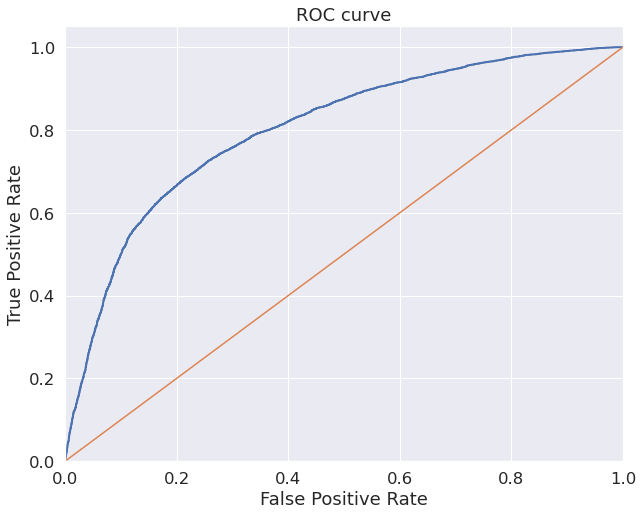

roc auc score: 0.800766409866558
log loss score: 0.5419752677470356
Confusion matrix, without normalization
[[5833 2987]
 [1839 6841]]


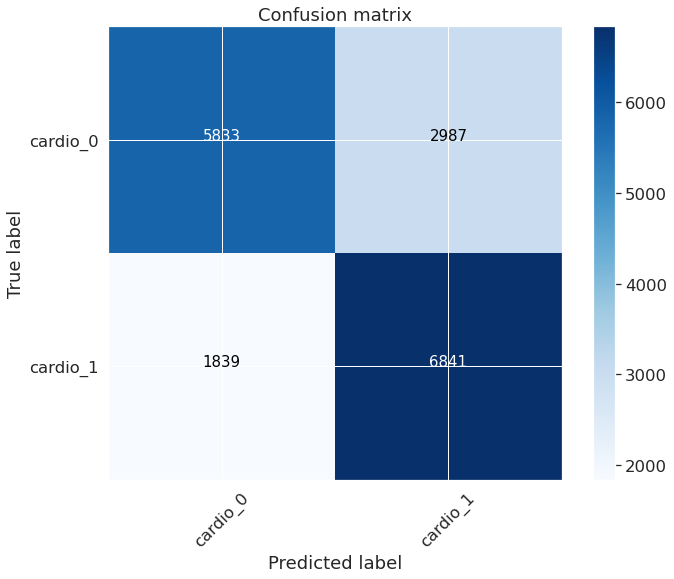

In [118]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', catb.CatBoostClassifier(random_state=21)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]


b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))


sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()


from sklearn.metrics import roc_auc_score, log_loss

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))


#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

score_list.append(['CatBoost', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1]), log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])])

### 6.xgboost

CV score is 0.7962156108988848+-0.004388386094897168
Best Threshold=0.347103, F-Score=0.738, Precision=0.665, Recall=0.828


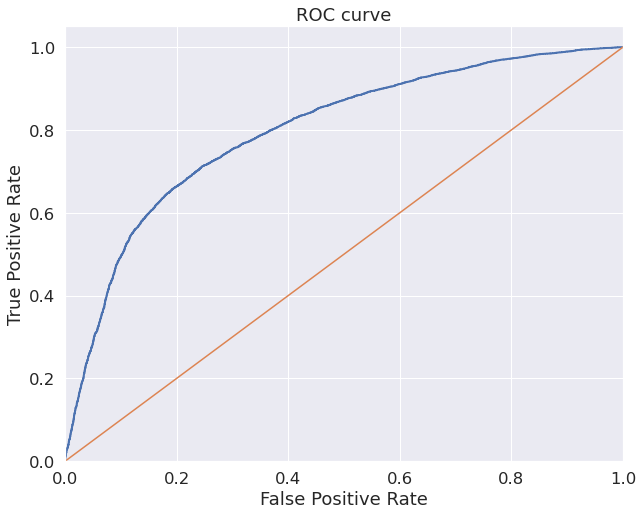

roc auc score: 0.7972277735979184
log loss score: 0.5471106087872626
Confusion matrix, without normalization
[[5202 3618]
 [1491 7189]]


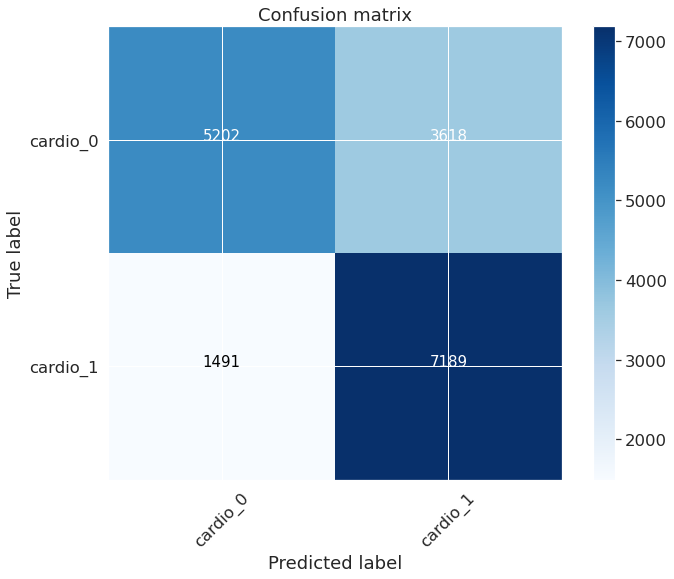

In [119]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', XGBClassifier(random_state=21)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]


b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))


sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()


from sklearn.metrics import roc_auc_score, log_loss

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))


#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

score_list.append(['XGBoost', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1]), log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])])

In [120]:
score_table = pd.DataFrame(score_list, columns = ['model', 'thresholds', 'fscore', 'precision', 'recall', 'roc_auc', 'log_loss'])

In [121]:
score_table

,model,thresholds,fscore,precision,recall,roc_auc,log_loss
0,LogReg,0.386937,0.730323,0.647431,0.837558,0.784035,0.577960
1,RandomForest,0.350000,0.718863,0.642669,0.815553,0.771037,0.599298
2,KNClass,0.400000,0.685863,0.588468,0.821889,0.694098,2.049547
3,lgbm,0.344797,0.739561,0.660803,0.839631,0.801689,0.540579
4,CatBoost,0.393618,0.739316,0.696103,0.788249,0.800766,0.541975
5,XGBoost,0.347103,0.737890,0.665248,0.828341,0.797228,0.547111


Вывод: лучшет всех для данной задачи без учета настройки гиперпараметров работает lgbm. У него выше fscore и recall, roc_auc. С учетом специфики задачи показатель recall если исходить из DS метрик для нас в целом важнее, чем precision. Но в дальнейшем необходимо подобрать гиперпараметры и возможно лучшей будет другая модель, также следует посчитать метрики для бизнеса, чтобы обеспечить самую высокую эффективность модели с точки зрения финансовых затрат.